# Medical Image Classification

**Company Use Case:**

**Approach:**

The following Notebook will show <span style="color:red">2 OR 3</span>. approaches to do this with ConcreteML.

**Dataset Source:**

The data used is provided by MedMNIST v2, a comprehensive collection of standardized biomedical images. It encompasses 12 datasets for 2D and 6 for 3D images, pre-processed into 28 x 28 (2D) or 28 x 28 x 28 (3D) with corresponding classification labels. With 708,069 2D images and 9,998 3D images, it supports various classification tasks, from binary/multi-class to ordinal regression and multi-label, catering to biomedical image analysis, computer vision, and machine learning research and education.

https://medmnist.com/

**Dataset  1:**

_PneumoniaMNIST_

MedMNIST Description:

The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.

https://zenodo.org/records/6496656/files/pneumoniamnist.npz?download=1

**Dataset 2:**

_BreastMNIST_

MedMNIST Description:

The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.

https://zenodo.org/records/6496656/files/breastmnist.npz?download=1

**Dataset 3:**

_OrganCMNIST_

MedMNIST Description:

The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.

https://zenodo.org/records/6496656/files/organcmnist.npz?download=1

# FHE Mode

In [46]:
mode = 'simulate'

# mode = 'execute'

# Imports

In [47]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output

# MedMNIST
import medmnist

# SciKit-Learn
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *

# XGBoost
from xgboost.sklearn import XGBClassifier

# PyTorch
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50, vgg16
from torchsummary import summary

# ConcreteML
from concrete.ml.sklearn import NeuralNetClassifier
from concrete.ml.torch.compile import compile_brevitas_qat_model

# Brevitas
import brevitas

In [48]:
# set random seed
np.random.seed(1)
torch.manual_seed(1)

# General Functions

In [49]:
################################################################################
# Logging (KICK AFTER BEING DONE)
################################################################################

def log_parameters(dataset, epochs, learning_rate, weight_decay, model, train_losses, train_accuracies, val_losses, val_accuracies):
    if os.path.isfile(f'{dataset}_Experiments.csv'):
        df = pd.read_csv(f'{dataset}_Experiments.csv')
        df = df.drop_duplicates()
        # append new row
        df = pd.concat([df, pd.DataFrame({
            'epochs': [epochs],
            'learning_rate': [learning_rate],
            'weight_decay': [weight_decay],
            'model': [str(model)],
            'final_train_loss': [train_losses[-1]],
            'final_train_accuracy': [train_accuracies[-1]],
            'final_val_loss': [val_losses[-1]],
            'final_val_accuracy': [val_accuracies[-1]]
            })])
        # save csv
        df.to_csv(f'{dataset}_Experiments.csv', index=False)

    else:
        df = pd.DataFrame({
        'epochs': [epochs],
        'learning_rate': [learning_rate],
        'weight_decay': [weight_decay],
        'model': [str(model)],
        'final_train_loss': [train_losses[-1]],
        'final_train_accuracy': [train_accuracies[-1]],
        'final_val_loss': [val_losses[-1]],
        'final_val_accuracy': [val_accuracies[-1]]
        })
        # save csv
        df.to_csv(f'{dataset}_Experiments.csv', index=False)
    
    return 'Parameters Logged!'

################################################################################
# Load Data
################################################################################

def load_data(dataset):

    '''
    Load data from MedMNIST

    Input:
        dataset (str): name of dataset

    Output:
        X_grayscale (tuple): (xtrain, xval, xtest) grayscale images
        X_rgb (tuple): (xtrain, xval, xtest) rgb images
        y (tuple): (ytrain, yval, ytest) labels
    '''

    # initialize DataClass
    DataClass = getattr(medmnist, dataset)
    # download data
    train_dataset = DataClass(split='train',download=True)
    eval_dataset = DataClass(split='val', download=True)
    test_dataset = DataClass(split='test', download=True)
    # to numpy array
    xtrain, ytrain = train_dataset.imgs, train_dataset.labels.flatten()
    xval, yval = eval_dataset.imgs, eval_dataset.labels.flatten()
    xtest, ytest = test_dataset.imgs, test_dataset.labels.flatten()
    # expand dimension (grayscale)
    # (channels=1, height=28, width=28)
    xtrain = np.expand_dims(xtrain, axis=1)
    xval = np.expand_dims(xval, axis=1)
    xtest = np.expand_dims(xtest, axis=1)

    clear_output()

    return xtrain, xval, xtest, ytrain, yval, ytest

################################################################################
# Preprocess Data
################################################################################

def plot_images(x_train, y_train, dataset):

    # plot sample images of each class
    n_classes = len(np.unique(y_train))

    fig, ax = plt.subplots(nrows=1, ncols=n_classes, figsize=(10, 5))
    for i in range(n_classes):
        ax[i].imshow(x_train[y_train.flatten()==i][0][0], cmap='gray')
        ax[i].set_title(f'Class {i}')
        ax[i].axis('off')
    fig.suptitle(dataset)
    plt.show()

################################################################################
# Plot Classification Metrics
################################################################################

def plot_classification_metrics(
    y_true: np.array,
    y_pred: np.array,
    plot_title: str = None
    ):

    '''
    Plots Classification Metrics

    Input:
      y_true = ground truth labels
      y_pred = prediction labels
      plot_title = title for results plot (optional)
    '''

    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    ax = ax.flatten()

    if len(np.unique(y_true)) == 2:
        accuracy = round(accuracy_score(y_true, y_pred),2)
        precision = round(precision_score(y_true, y_pred),2)
        recall = round(recall_score(y_true, y_pred),2)
        f1 = round(f1_score(y_true, y_pred),2)
        roc_auc = round(roc_auc_score(y_true, y_pred), 2)
        ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1', 'RocAuc'], [accuracy, precision, recall, f1, roc_auc])
    else:
        accuracy = round(accuracy_score(y_true, y_pred),2)
        precision = round(precision_score(y_true, y_pred, average='macro'),2)
        recall = round(recall_score(y_true, y_pred, average='macro'),2)
        f1 = round(f1_score(y_true, y_pred, average='macro'),2)
        ax[0].bar(['Accuracy', 'Precision', 'Recall', 'F1'], [accuracy, precision, recall, f1])


    # barchart of metrics for each classifier
    ax[0].set_title('Classifier Metrics')
    ax[0].set_ylim(0,1)
    ax[0].bar_label(ax[0].containers[0], label_type='center')

    # confusion matrix for each classifier
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax[1], cmap='Blues', colorbar=False)
    ax[1].set_title('Classifier Confusion Matrix')

    plt.suptitle(plot_title)
    plt.tight_layout()

    plt.show()

# Load Data

In [50]:
data = load_data(dataset='PneumoniaMNIST')

xtrain_pneumonia, xval_pneumonia, xtest_pneumonia, ytrain_pneumonia, yval_pneumonia, ytest_pneumonia = data

data = load_data(dataset='BreastMNIST')

xtrain_breast, xval_breast, xtest_breast, ytrain_breast, yval_breast, ytest_breast = data

data = load_data(dataset='OrganCMNIST')

xtrain_organ, xval_organ, xtest_organ, ytrain_organ, yval_organ, ytest_organ = data

In [51]:
print(f'Grayscale Shape PneumoniaMNIST: {xtrain_pneumonia.shape}')
print('\n')
print(f'Grayscale Shape BreastMNIST: {xtrain_breast.shape}')
print('\n')
print(f'Grayscale Shape OrganCMNIST: {xtrain_organ.shape}')

Grayscale Shape PneumoniaMNIST: (4708, 1, 28, 28)


Grayscale Shape BreastMNIST: (546, 1, 28, 28)


Grayscale Shape OrganCMNIST: (13000, 1, 28, 28)


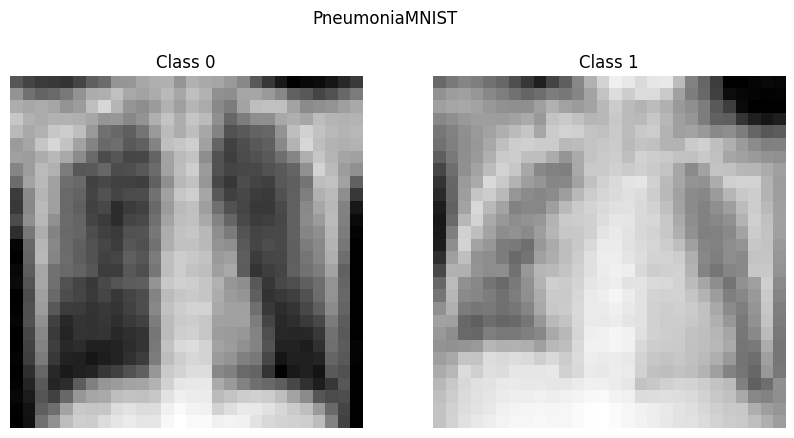

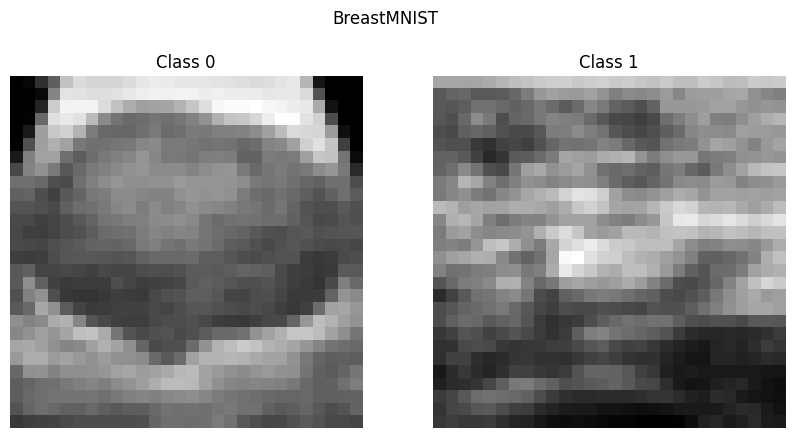

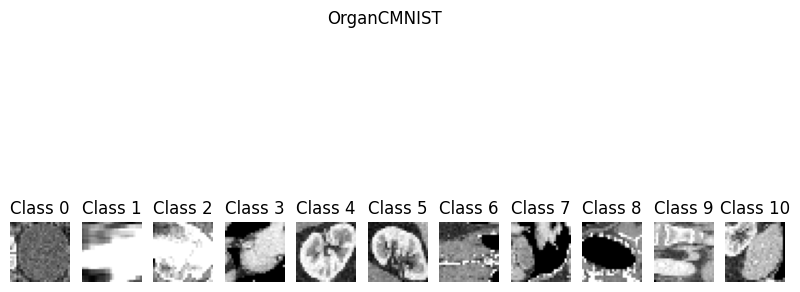

In [52]:
plot_images(xtrain_pneumonia, ytrain_pneumonia, dataset='PneumoniaMNIST')
plot_images(xtrain_breast, ytrain_breast, dataset='BreastMNIST')
plot_images(xtrain_organ, ytrain_organ, dataset='OrganCMNIST')

# Preprocessing

In [53]:
# normalize grayscale images for generic CNN

# PneumoniaMNIST
xtrain_pneumonia, xval_pneumonia, xtest_pneumonia = xtrain_pneumonia/255, xval_pneumonia/255, xtest_pneumonia/255

# BreastMNIST
xtrain_breast, xval_breast, xtest_breast = xtrain_breast/255, xval_breast/255, xtest_breast/255

# OrganCMNIST
xtrain_organ, xval_organ, xtest_organ = xtrain_organ/255, xval_organ/255, xtest_organ/255

# Modelling

## Approach 1: Artificial Neural Network

### Scikit-Learn

In [54]:
class SklearnANN():

    def __init__(self):
        self.model = None
        self.log = {
            'train': 0,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, x_train, y_train, x_val, y_val, epochs=100, learning_rate=0.0001, weight_decay=0.0001, neuron_factor=0.7, plot=True):
        # reshape data
        x_train, x_val = x_train.reshape(x_train.shape[0], -1), x_val.reshape(x_val.shape[0], -1)
        # initialize model
        self.model = MLPClassifier(
            hidden_layer_sizes=(int(x_train.shape[1]*neuron_factor),int(x_train.shape[1]*neuron_factor*neuron_factor)),
            learning_rate='adaptive',
            learning_rate_init=learning_rate,
            alpha=weight_decay,
        )
        # train model
        train_l, val_l, train_score, val_score = [], [], [], []
        for epoch in tqdm(range(epochs)):
            start_time = time.time()
            self.model.partial_fit(x_train, y_train, classes=np.unique(y_train))
            self.log['train'] += time.time() - start_time
            # curve metrics
            pred_train, pred_val  = self.model.predict(x_train), self.model.predict(x_val)
            train_l.append(log_loss(y_train, pred_train))
            val_l.append(log_loss(y_val, pred_val))
            train_score.append(accuracy_score(y_train, pred_train))
            val_score.append(accuracy_score(y_val, pred_val))

        # plot results
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1]. set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

    def evaluate(self, X):
        # reshape data for sklearn
        X = X.reshape(X.shape[0], -1)
        # predict
        start_time = time.time()
        pred = self.model.predict(X)
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]

        return pred

#### PneumoniaMNIST

100%|██████████| 100/100 [00:30<00:00,  3.23it/s]


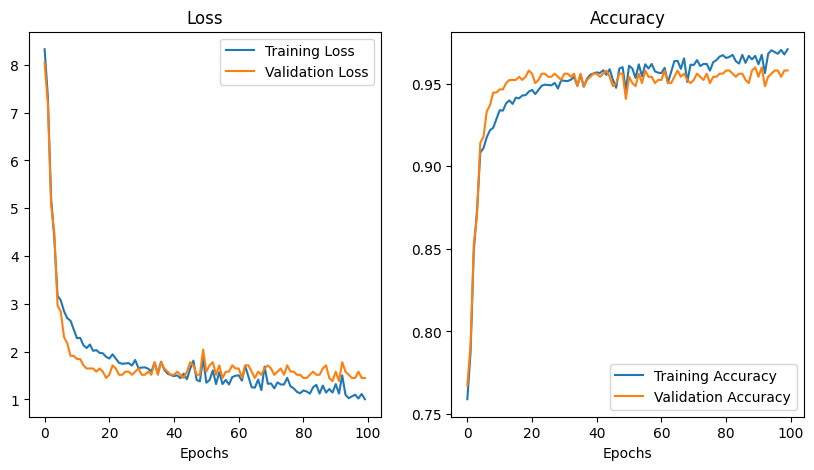

In [55]:
# initialize model
sklearn_ann = SklearnANN()

# train model
sklearn_ann.train(
    x_train=xtrain_pneumonia,
    y_train=ytrain_pneumonia,
    x_val=xval_pneumonia,
    y_val=yval_pneumonia,
    epochs=100,
    learning_rate=0.0001,
    weight_decay=0.0001,
    neuron_factor=0.25,
    plot=True
    )

# evaluate model
ypred_ann_sklearn = sklearn_ann.evaluate(xtest_pneumonia)

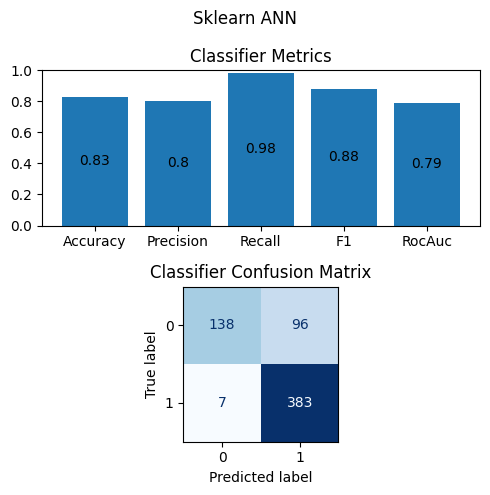

In [56]:
plot_classification_metrics(y_true=ytest_pneumonia, y_pred=ypred_ann_sklearn, plot_title='Sklearn ANN')

#### BreastMNIST

100%|██████████| 80/80 [00:03<00:00, 22.95it/s]


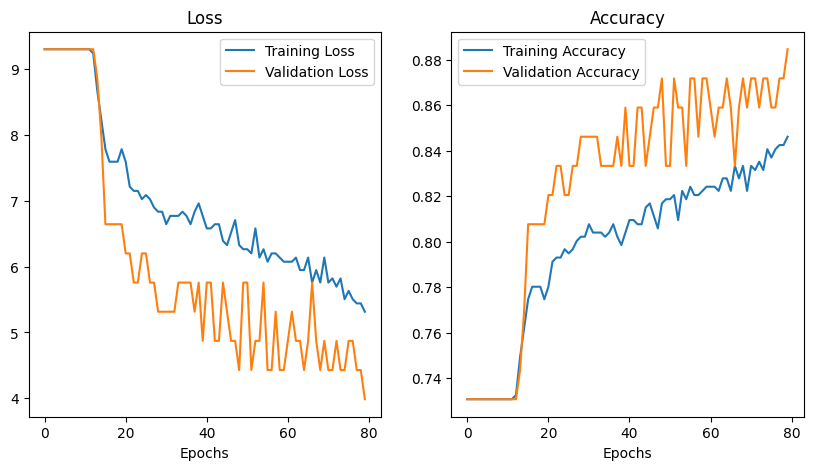

In [57]:
# initialize model
sklearn_ann = SklearnANN()

# train model
sklearn_ann.train(
    x_train=xtrain_breast,
    y_train=ytrain_breast,
    x_val=xval_breast,
    y_val=yval_breast,
    epochs=80,
    learning_rate=0.0001,
    weight_decay=0.0001,
    neuron_factor=0.25,
    plot=True
    )

# evaluate model
ypred_ann_sklearn = sklearn_ann.evaluate(xtest_breast)

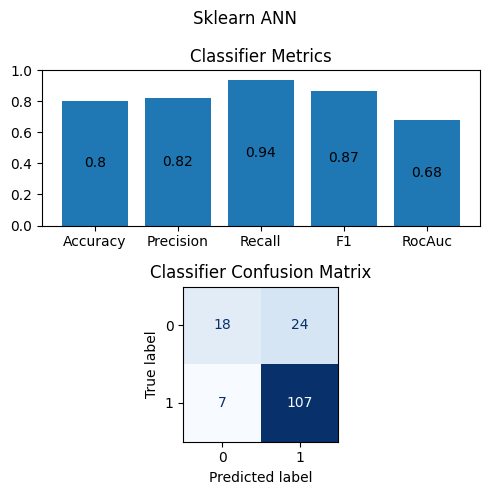

In [58]:
plot_classification_metrics(y_true=ytest_breast, y_pred=ypred_ann_sklearn, plot_title='Sklearn ANN')

### Concrete

In [ ]:
class ConcreteANN():
    
    def __init__(self, n_bits=2):
        self.n_bits = n_bits
        self.model = None
        self.log = {
            'train': 0,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, x_train, y_train, x_val, y_val, epochs=100, learning_rate=0.0001, weight_decay=0.0001, neuron_factor=0.7, plot=True):
        # reshape data
        x_train, x_val = x_train.reshape(x_train.shape[0], -1), x_val.reshape(x_val.shape[0], -1)
        # initialize model
        self.model = NeuralNetClassifier(
            lr=learning_rate,
            max_epochs=epochs,
            
        )
        # train model
        train_l, val_l, train_score, val_score = [], [], [], []
        for epoch in tqdm(range(epochs)):
            start_time = time.time()
            ################################################################################################################################
            # partial_fit maybe called different in Concrete --> run_single_epoch? warm start other option? get loss an metrics from skorch?
            ################################################################################################################################
            self.model.partial_fit(x_train, y_train, classes=np.unique(y_train))
            self.log['train'] += time.time() - start_time
            # curve metrics
            pred_train, pred_val  = self.model.predict(x_train), self.model.predict(x_val)
            train_l.append(log_loss(y_train, pred_train))
            val_l.append(log_loss(y_val, pred_val))
            train_score.append(accuracy_score(y_train, pred_train))
            val_score.append(accuracy_score(y_val, pred_val))

        # plot results
        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1]. set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

## Approach 2: Convolutional Neural Network

### PyTorch

In [39]:
class TorchCNN():
    def __init__(self, model):
        self.model = model
        self.log = {
            'train': 0,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, x_train, y_train, x_val, y_val, epochs=30, learning_rate=0.0001, weight_decay=0.0001, plot=True):
        # get number of classes
        n_classes = len(np.unique(y_train))
        # data to tensor
        x_train, y_train = torch.tensor(x_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long).flatten()
        x_val, y_val = torch.tensor(x_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.long).flatten()
        # criterion
        criterion = torch.nn.CrossEntropyLoss()
        # optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # train loop
        train_l, val_l, train_score, val_score= [], [], [], []
        for epoch in tqdm(range(epochs)):

            # set model to train mode
            self.model.train()
            start_time = time.time()
            for i in range(0, len(x_train), 1):
                inputs, labels = x_train[i:i+1], y_train[i:i+1]
                # forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
            epoch_time = time.time() - start_time
            self.log['train'] += epoch_time

            # set model to eval mode
            self.model.eval()
            # calculate curve metrics
            with torch.no_grad():
                train_outputs = self.model(x_train)
                train_loss = criterion(train_outputs, y_train)
                predicted = torch.argmax(train_outputs, dim=1)
                train_accuracy = accuracy_score(predicted.detach().numpy(), y_train.detach().numpy())*100

                val_outputs = self.model(x_val)
                val_loss = criterion(val_outputs, y_val)
                predicted = torch.argmax(val_outputs, dim=1)
                val_accuracy = accuracy_score(predicted.detach().numpy(), y_val.detach().numpy())*100

            train_l.append(train_loss.item())
            val_l.append(val_loss.item())
            train_score.append(train_accuracy)
            val_score.append(val_accuracy)

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1]. set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

        log_parameters(dataset, epochs, learning_rate, weight_decay, self.model, train_l, train_score, val_l, val_score)

        return self

    def evaluate(self, X):
        # data to tensor
        X = torch.tensor(X, dtype=torch.float)
        # set model to eval mode
        self.model.eval()
        # predict
        start_time = time.time()
        with torch.no_grad():
            # predict each sample individually
            outputs = [self.model(X[[i]]) for i in tqdm(range(X.shape[0]))]
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # get binary predictions
        y_pred = torch.argmax(torch.cat(outputs), dim=1).detach().numpy().flatten()

        return y_pred

#### PneumoniaMNIST

In [40]:
n_classes = len(np.unique(ytrain_pneumonia))

torch_model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.AvgPool2d(kernel_size=2, stride=2),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=169, out_features=n_classes, bias=True)
    )

summary(torch_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              10
              ReLU-2            [-1, 1, 26, 26]               0
         AvgPool2d-3            [-1, 1, 13, 13]               0
           Flatten-4                  [-1, 169]               0
            Linear-5                    [-1, 2]             340
Total params: 350
Trainable params: 350
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.00
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


100%|██████████| 20/20 [02:19<00:00,  6.99s/it]


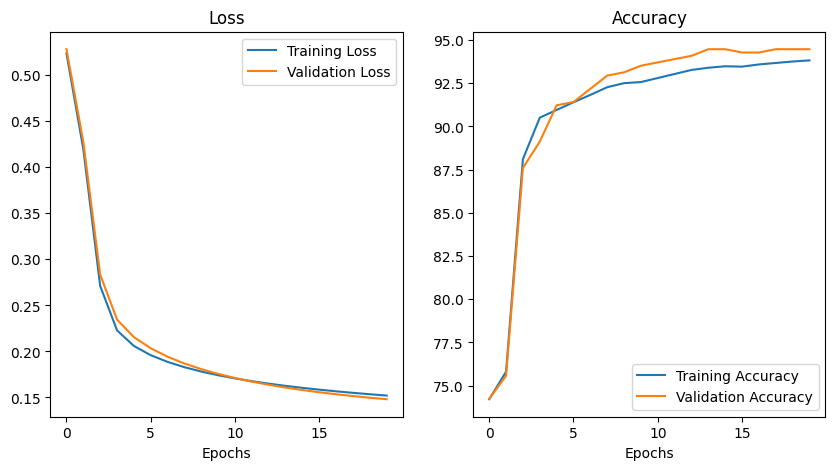

100%|██████████| 624/624 [00:00<00:00, 4406.81it/s]


In [41]:
dataset = 'PneumoniaMNIST'
epochs = 20
learning_rate = 0.0001
weight_decay = 0.0001

# initialize model
torch_cnn = TorchCNN(model=torch_model)

# train model
torch_cnn = torch_cnn.train(
    x_train=xtrain_pneumonia,
    y_train=ytrain_pneumonia,
    x_val=xval_pneumonia,
    y_val=yval_pneumonia,
    epochs=epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay
    )

# evaluate model
ypred_torch = torch_cnn.evaluate(xtest_pneumonia)

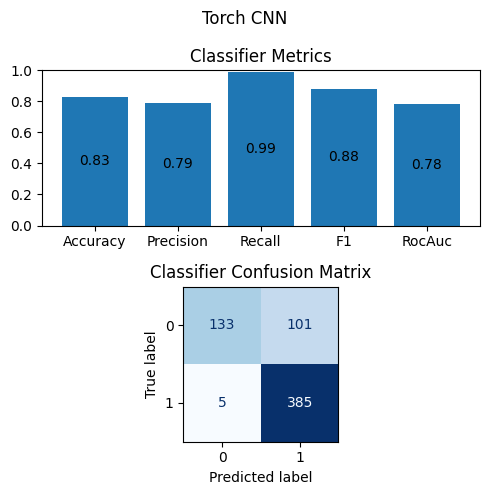

In [42]:
plot_classification_metrics(ytest_pneumonia, ypred_torch, plot_title='Torch CNN')

In [ ]:
# experiments = pd.read_csv(f'PneumoniaMNIST_Experiments.csv').sort_values(by='final_val_accuracy', ascending=False)
# experiments

#### BreastMNIST

### Concrete

In [43]:
class ConcreteCNN():
    def __init__(self, model):
        self.model = model
        self.log = {
            'train': 0,
            'compile': None,
            'keygen': None,
            'evaluate_total': None,
            'evaluate_sample': None
        }

    def train(self, x_train, y_train, x_val, y_val, epochs=30, learning_rate=0.0001, weight_decay=0.0001, plot=True):
        # get number of classes
        n_classes = len(np.unique(y_train))
        # data to tensor
        x_train, y_train = torch.tensor(x_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long).flatten()
        x_val, y_val = torch.tensor(x_val, dtype=torch.float), torch.tensor(y_val, dtype=torch.long).flatten()
        # criterion
        criterion = torch.nn.CrossEntropyLoss()
        # optimizer
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # train loop
        train_l, val_l, train_score, val_score= [], [], [], []
        for epoch in tqdm(range(epochs)):

            # set model to train mode
            self.model.train()
            start_time = time.time()
            for i in range(0, len(x_train), 1):
                inputs, labels = x_train[i:i+1], y_train[i:i+1]
                # forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
            epoch_time = time.time() - start_time
            self.log['train'] += epoch_time

            # set model to eval mode
            self.model.eval()
            # calculate curve metrics
            with torch.no_grad():
                train_outputs = self.model(x_train)
                train_loss = criterion(train_outputs, y_train)
                predicted = torch.argmax(train_outputs, dim=1)
                train_accuracy = accuracy_score(predicted.detach().numpy(), y_train.detach().numpy())*100

                val_outputs = self.model(x_val)
                val_loss = criterion(val_outputs, y_val)
                predicted = torch.argmax(val_outputs, dim=1)
                val_accuracy = accuracy_score(predicted.detach().numpy(), y_val.detach().numpy())*100

            train_l.append(train_loss.item())
            val_l.append(val_loss.item())
            train_score.append(train_accuracy)
            val_score.append(val_accuracy)

        if plot:
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].plot(train_l, label='Training Loss')
            ax[0].plot(val_l, label='Validation Loss')
            ax[0].set_xlabel('Epochs')
            ax[0].set_title('Loss')
            ax[0].legend()
            ax[1].plot(train_score, label='Training Accuracy')
            ax[1].plot(val_score, label='Validation Accuracy')
            ax[1]. set_xlabel('Epochs')
            ax[1].set_title('Accuracy')
            ax[1].legend()
            plt.show()

        log_parameters(dataset+'_Brevitas', epochs, learning_rate, weight_decay, self.model, train_l, train_score, val_l, val_score)

        # compile model
        start_time = time.time()
        self.model = compile_brevitas_qat_model(self.model, x_train)
        self.log['compile'] = time.time() - start_time

        return self
    
    def evaluate(self, X, fhe='simulate'):
        # keygen
        start_time = time.time()
        self.model.fhe_circuit.keygen(force=True)
        self.log['keygen'] = time.time() - start_time
        # predict
        start_time = time.time()
        with torch.no_grad():
            # predict each sample individually
            outputs = [self.model.forward(X[[i]], fhe=fhe) for i in tqdm(range(X.shape[0]))]
        self.log['evaluate_total'] = time.time() - start_time
        self.log['evaluate_sample'] = self.log['evaluate_total']/X.shape[0]
        # get binary predictions
        y_pred = torch.argmax(torch.cat(outputs), dim=1).detach().numpy().flatten()

        return y_pred

#### PneumoniaMNIST

In [44]:
n_bits = 2

brevitas_model = torch.nn.Sequential(
    # entry point of a network has to be a QuantIdentity layer
    # to quantize the inputs
    brevitas.nn.QuantIdentity(bit_width=n_bits, return_quant_tensor=True),
    # brevitas QuantConv2d layer
    brevitas.nn.QuantConv2d(in_channels=1, out_channels=1, kernel_size=3, weight_bit_width=n_bits),
    # brevitas QuantReLU layer
    brevitas.nn.QuantReLU(bit_width=n_bits),
    # torch AvgPool2d layer
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    # after a PyTorch layer there needs to follow a QuantIdentity layer
    # to make sure the inputs are quantized correctly
    brevitas.nn.QuantIdentity(bit_width=n_bits, return_quant_tensor=True),
    # PyTorch flatten layer
    torch.nn.Flatten(),
    # again a QuantIdentity layer after the PyTorch layer
    brevitas.nn.QuantIdentity(bit_width=n_bits, return_quant_tensor=True),
    # brevitas QuantLinear (output) layer
    brevitas.nn.QuantLinear(in_features=169, out_features=2, bias=True, weight_bit_width=n_bits)
)

In [45]:
dataset = 'PneumoniaMNIST'
epochs = 20
learning_rate = 0.0001
weight_decay = 0.0001

# initialize model
concrete_cnn = ConcreteCNN(model=brevitas_model)

# train model
concrete_cnn = concrete_cnn.train(
    x_train=xtrain_pneumonia,
    y_train=ytrain_pneumonia,
    x_val=xval_pneumonia,
    y_val=yval_pneumonia,
    epochs=epochs,
    learning_rate=learning_rate,
    weight_decay=weight_decay
    )

# evaluate model
ypred_concrete = concrete_cnn.evaluate(xtest_pneumonia)

 15%|█▌        | 3/20 [03:08<17:45, 62.68s/it]


KeyboardInterrupt: 

In [ ]:
plot_classification_metrics(ytest_pneumonia, ypred_concrete, plot_title='Concrete CNN')

#### BreastMNIST

## Approach 3: Pre-Trained Model & ANN